# Tracking Data Visualization

The following notebook includes visualizations to output predicted probabilities as the play is devloping

(<Figure size 1200x633 with 1 Axes>, <AxesSubplot:>)

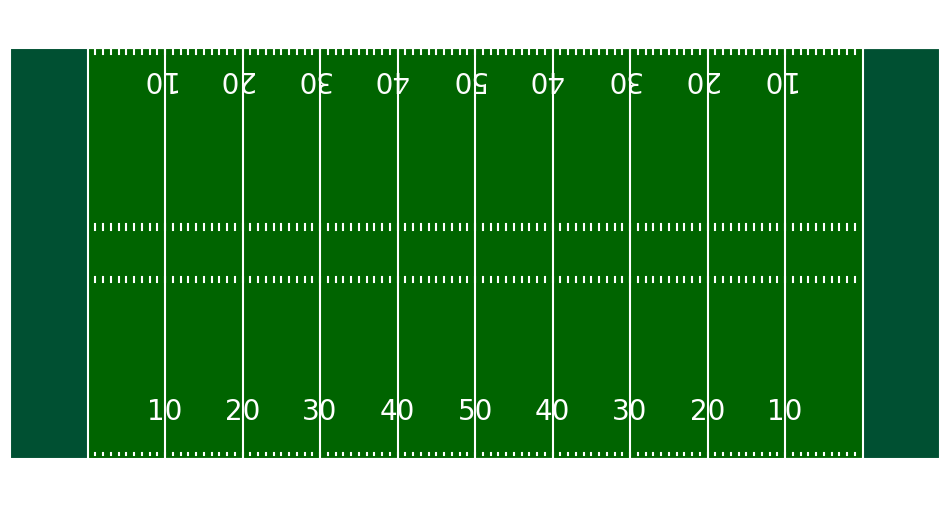

In [4]:
#Run the trackingDataviz notebook
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()

In [5]:
def animate_player_movement(preds_data, tracking_data, plays, gameId="", playId="", pred_column="softmax_probs"):
    """
    Animates the player movement for the given game and play ID within a Jupyter notebook.
    """
    %matplotlib inline
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML

    # Split the string at the periods and expand into separate columns
    preds_data[['gameId', 'playId', 'extra']] = preds_data['gamePlayId'].str.split('.', expand=True)

    # Convert the first two new columns to float
    preds_data['gameId'] = preds_data['gameId'].astype(float)
    preds_data['playId'] = preds_data['playId'].astype(float)

    if gameId == "":
        gameId = tracking_data['gameId'].unique()[0]
        playId = tracking_data['playId'].unique()[0]

    # Subset the tracking data to the gameId and playId
    tracking_data = tracking_data[(tracking_data['gameId'] == gameId) & (tracking_data['playId'] == playId)]
    preds_data = preds_data[(preds_data['gameId'] == gameId) & (preds_data['playId'] == playId)]
    plays = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)]

    # Obtain ball carrier ID and offensive team
    ball_carrier = plays["ballCarrierId"].iloc[0]
    offense_team = plays["possessionTeam"].iloc[0]

    # Merge data
    play_data = tracking_data.merge(preds_data, on=["gameId", "playId", "frameId", "nflId"], how="left")
    
    # Change the frameId to int and sort the data
    play_data["frameId"] = play_data["frameId"].astype(int)
    play_data = play_data.sort_values(by='frameId')

    # Filter out frames where all 'softmax_probs' values are NA
    play_data = play_data.groupby('frameId').filter(lambda x: not x[pred_column].isna().all())

    # Create the football field
    fig, ax = create_football_field()


    # Initialize the scatter plot for player positions on top of the football field
    scat = ax.scatter([], [], s=40, color=[], zorder=5)

    # Initialize a second scatter plot for the transparent points
    transparent_scat = ax.scatter([], [], s=[], color='blue', alpha=0.25, zorder=4)

    def update(frame_number):
        # Update player and ball positions for the given frame
        frame_data = play_data[play_data.frameId == frame_number]

        # Lists for original scatter plot properties
        positions = []
        colors = []

        # Initialize a list for the sizes of the transparent points
        sizes = []
        positions_offense = []



        for index, row in frame_data.iterrows():
            positions.append([row['x'], row['y']])
            
            # Determine color based on team and ball carrier
            if row['nflId'] == ball_carrier:
                colors.append('black')
            elif row['club'] == offense_team:
                colors.append('red')
            else:
                colors.append('blue')


            # Determine size based on softmax_probs for defensive players
            if row['club'] != offense_team:
                #append offensive players
                positions_offense.append([row['x'],row['y']])
                # Adjust size based on softmax_probs, with a scaling factor for visibility
                size = row[pred_column] * 500 + 500  # Example scaling factor
                sizes.append(size)
            else:
                sizes.append(0)  # Offensive players remain the same size



        # Update the original scatter plot
        scat.set_offsets(positions)
        scat.set_color(colors)

        #update the original predictions
        transparent_scat.set_offsets(positions_offense)
        transparent_scat.set_sizes(sizes)

        return scat,transparent_scat

    # Create the animation
    anim = FuncAnimation(fig, update, frames=range(play_data.frameId.min(), play_data.frameId.max() + 1), interval=700, blit=True)

    # Use HTML to create a video within the notebook
    return HTML(anim.to_html5_video())


In [ ]:
def softmax(dataframe):
    # Group the data by gamePlayId and frameId
    grouped = dataframe.groupby(['gamePlayId', 'frameId'])
    
    # Initialize an empty DataFrame to store the results
    result_df = pd.DataFrame()
    
    # Iterate over groups
    for group_name, group_data in grouped:
        # Apply softmax to model_probs_GRU column within the group
        softmax_values = np.exp(group_data['model_probs_GRU']) / np.sum(np.exp(group_data['model_probs_GRU']))
        
        # Add the softmax values to the group_data as a new column
        group_data['softmax_probs'] = softmax_values
        
        # Append the updated group_data to the result DataFrame
        result_df = pd.concat([result_df, group_data])
    
    return result_df

In [ ]:
#Example usage
#animate_player_movement(pred_df_gru, tracking, plays)

In [8]:
#Read data
import pandas as pd

games = pd.read_csv("../../Data/games.csv")
players = pd.read_csv("../../Data/players.csv")
plays = pd.read_csv("../../Data/plays.csv")
tracking = pd.read_csv("../../Data/tracking_week_1.csv")
predictions = pd.read_csv("../../Data/model_results.csv")

In [6]:
predictions

,gamePlayId,gameId,playId,nflId,frameId,tackle_binary_single,prediction
0,2022090800.0529.0,2.022091e+09,529.0,38577.0,19.0,0,0.003838
1,2022090800.0529.0,2.022091e+09,529.0,38577.0,20.0,0,0.003388
2,2022090800.0529.0,2.022091e+09,529.0,38577.0,21.0,0,0.001570
3,2022090800.0529.0,2.022091e+09,529.0,38577.0,22.0,0,0.004507
4,2022090800.0529.0,2.022091e+09,529.0,38577.0,23.0,0,0.005843
...,...,...,...,...,...,...,...
556716,2022110700.03707.0,2.022111e+09,3707.0,53505.0,50.0,0,0.004556
556717,2022110700.03707.0,2.022111e+09,3707.0,53505.0,51.0,0,0.004612
556718,2022110700.03707.0,2.022111e+09,3707.0,53505.0,52.0,0,0.005724
556719,2022110700.03707.0,2.022111e+09,3707.0,53505.0,53.0,0,0.004554


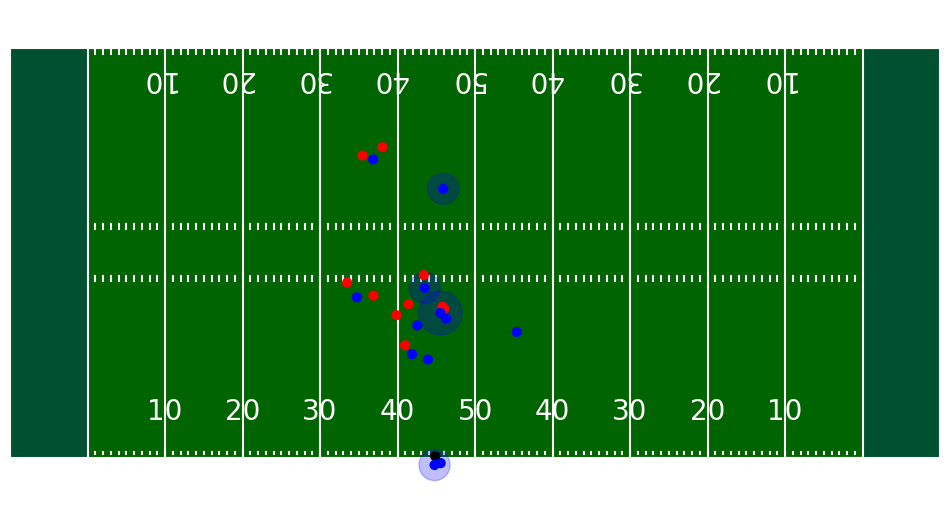

In [9]:
animate_player_movement(predictions, tracking, plays, gameId = 2022091108, playId=2983, pred_column="prediction")